In [48]:
%matplotlib inline
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

from synthetic_data import load_data_by_gtype
from ic import make_partial_cascade
from graph_generator import add_p_and_delta
from plot_utils import richify_line_style


In [58]:
ps = np.linspace(0.1, 1.0, 19)

In [60]:
def experiment(g, p, N):
    numer, denum = 0, 0
    g = add_p_and_delta(g, p, 1)
    for i in range(N):
        source, _, infection_times, _ = make_partial_cascade(g, 0.01)
        sp_len = nx.shortest_path_length(g, source=source)

        total_infection = sum(1 for l in infection_times.values() if not np.isinf(l))
        n_matches = sum(1 for n, l in infection_times.items()
                        if not np.isinf(l) and sp_len[n] == l)
        numer += n_matches
        denum += total_infection
    return numer, denum

In [61]:
gtypes = [('grid', '2-4'),
          ('er', '2-8'), 
          ('barabasi', '2-8'),
          ('pl-tree', '2-8'),
          ('kr-hier', '10-10'),
          ('kr-peri', '10-10'),
          ('kr-rand', '10-10')]
result = {}
for gtype, param in tqdm(gtypes):
    g = load_data_by_gtype(gtype, param)[0]
    rows = Parallel(n_jobs=-1)(delayed(experiment)(g, p, 100) for p in ps)
    result[gtype] = np.array(rows)

100%|██████████| 7/7 [00:33<00:00,  5.36s/it]


In [66]:
result['grid']

array([[  247,   253],
       [  300,   312],
       [  350,   382],
       [  447,   551],
       [  557,   689],
       [  777,  1230],
       [ 1049,  1908],
       [ 1877,  5007],
       [ 1914,  8341],
       [ 3720, 14909],
       [ 4917, 20051],
       [ 7912, 22295],
       [11724, 24599],
       [14416, 25266],
       [17988, 25478],
       [20114, 25559],
       [22974, 25586],
       [24642, 25597],
       [25600, 25600]])

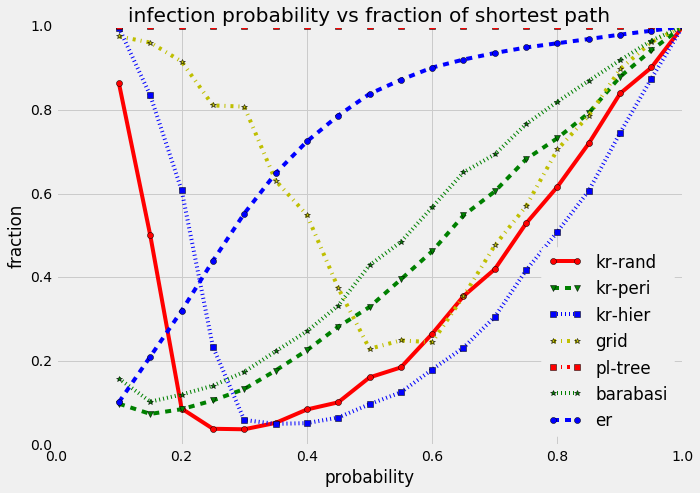

In [65]:
richify_line_style(plt)
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
for g, m in result.items():
    ax.plot(ps, m[:, 0] / m[:, 1])
ax.legend(list(result.keys()), loc='lower right')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title('infection probability vs fraction of shortest path')
ax.set_xlabel('probability')
ax.set_ylabel('fraction')